# Load the dependencies needed for the data

In [1]:
%pylab inline
from netCDF4 import Dataset
import pandas as pd
from scipy.interpolate import interp1d, interp2d
import seawater as sw
from glob import glob
import cmocean
import math
import gsw
import scipy.io as sci
import buoyancy_glider_utils as bgu
import gzip
import scipy.io as sio
from tqdm import tqdm_notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
def date_plot(x, y, c='k', lw=1, label='label'):
    
    plot_date(x, y, ms=0, lw=lw, ls='-', c=c, label=label)
    
    return

In [3]:
rcParams.update({'font.size': 13})

rcParams['lines.linewidth'] = 1.5
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13
rcParams['ytick.direction'] = 'in'
rcParams['xtick.direction'] = 'in'
rcParams.update({'axes.edgecolor':'k', 'xtick.color':'k', 'ytick.color':'k', 'axes.grid':True})
rcParams['axes.axisbelow'] = True
rcParams['lines.color'] = 'k'
rcParams.update({'axes.grid':True, 'grid.linestyle':'solid', 'grid.color':'k', 'axes.linewidth':1})
rcParams['axes.labelcolor'] ='k'

rcParams['axes.axisbelow'] = False

rcParams.update({'xtick.major.size': 5})
rcParams.update({'ytick.major.size': 5})
rcParams.update({'xtick.major.width': 1.5})
rcParams.update({'ytick.major.width': 1.5})
rcParams.update({'figure.figsize': [12, 5]})
rcParams.update({'figure.titlesize':'small'})

rcParams['lines.color'] = 'k'
rcParams.update({'axes.grid':False, 'grid.linestyle':'solid', 'grid.color':'k', 'axes.linewidth':1.5})
rcParams['axes.labelcolor'] ='k'

execfile("/Users/Marcel/Google Drive/PhD/Python/modules/find_nearest.py")

from scipy.interpolate import griddata

# Raw seaglider data to optimally interpolated data

## SOSCEX 1

LOAD THE DATA FROM THE NETCDF FILES USING LUKE'S BUOYANCY GLIDER PACKAGE

In [15]:
fname = '/Users/Marcel/Google Drive/Data/SOCCO_gliders/soscex1/sg543/*.nc'
dat = bgu.seaglider.load_basestation_netCDF_files(fname, verbose=True)

df = dat.load_multiple_vars([
    'temperature',
    'salinity',
    'density',
    'pressure',
    'depth'
])

x = df.dives
y = df.ctd_depth
t = df.ctd_time
td = bgu.tools.calc_dive_time_avg(t, x)

Dimension: sg_data_point
	[temperature, salinity, density, pressure, depth, ulatitude, uctd_time, uctd_depth, ulongitude, dives]


100%|██████████| 477/477 [00:06<00:00, 75.96it/s]


In [417]:
dpt_curr_e = dat.depth_avg_curr_east_gsm.values
dpt_curr_n = dat.depth_avg_curr_north_gsm.values

sfc_curr_e = dat.surface_curr_east.values
sfc_curr_n = dat.surface_curr_north.values

lon_curr = dat.log_gps_lon.values
lat_curr = dat.log_gps_lat.values


100%|██████████| 477/477 [00:03<00:00, 152.89it/s]


Cleaning the bad data points

In [16]:
temp = bgu.calc_physics(dat.temperature.values, x, y, iqr_multiplier=2, neighbourhood_size_dives=20, neighbourhood_size_depth=100)
salt = bgu.calc_physics(dat.salinity.values, x, y, iqr_multiplier=2, neighbourhood_size_dives=20, neighbourhood_size_depth=100)


Physics Variable:
	Mask bad data:
		neighbourhood (dives=20, depth=100m) interquartile range (IQR=2) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)

Physics Variable:
	Mask bad data:
		neighbourhood (dives=20, depth=100m) interquartile range (IQR=2) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)


CHANGE THE DATES FROM DATE TIME TO DATENUM FOR MATLAB FORMATTING

In [17]:
t=date2num(list(dat.temperature.data.ctd_time))

Calcualte the density from Luke's buoyancy glider package

In [18]:
# Calc density:
density = bgu.physics.calc_potential_density(salt,temp,df.pressure,df.latitude,df.longitude,pres_ref = 0)
dens = bgu.calc_physics(density, df.dives, df.depth)


Physics Variable:
	Mask bad data:
		neighbourhood (dives=40, depth=40m) interquartile range (IQR=3) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)


PUT THE DATA INTO A DICTIONARY AND SAVE INTO A MAT FILE

In [19]:
d = {'temp' : temp,
     'salt' : salt,
     'dens' : dens,
     'depth': dat.temperature.data.ctd_depth.values,
     'lats' : dat.latitude.values,
     'lons' : dat.longitude.values,
     'time'  : t}

sio.savemat('/Users/Marcel/Google Drive/Data/SOCCO_gliders/optimal_interpolated_grids/soscex1/soscex1_raw_sg_data.mat', d)

In [44]:
bgu.grid_data?

In [36]:
s1_temp_raw_grid = bgu.grid_data(d['temp'], df.dives, df.ctd_depth, bins=arange(1000), as_xarray=True)

## SOSCEx 2

### Part 1: Seaglider 574

In [62]:
fname = '/Users/Marcel/Google Drive/Data/SOCCO_gliders/soscex2/sg574_saz/*.nc'
dat = bgu.seaglider.load_basestation_netCDF_files(fname, verbose=True)

df1 = dat.load_multiple_vars([
    'temperature',
    'salinity',
    'density',
    'pressure',
    'depth'
])

x = df1.dives
y = df1.ctd_depth
t = df1.ctd_time
td = bgu.tools.calc_dive_time_avg(t, x)



Dimension: sg_data_point
	[temperature, salinity, density, pressure, depth, ulatitude, uctd_time, uctd_depth, ulongitude, dives]


100%|██████████| 188/188 [00:03<00:00, 54.40it/s]


In [63]:
df1.salinity[df.salinity<34.1] = NaN
df1.salinity[df.salinity>34.6] = NaN

/Users/Marcel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Marcel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [64]:
temp1 = bgu.calc_physics(df1.temperature, x, y, iqr_multiplier=2, neighbourhood_size_dives=20, neighbourhood_size_depth=100)
salt1 = bgu.calc_physics(df1.salinity, x, y, iqr_multiplier=2, neighbourhood_size_dives=40, neighbourhood_size_depth=100)


temperature:
	Mask bad data:
		neighbourhood (dives=20, depth=100m) interquartile range (IQR=2) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)

salinity:
	Mask bad data:
		neighbourhood (dives=40, depth=100m) interquartile range (IQR=2) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)


### Part 2: Seaglider 543

In [65]:
fname = '/Users/Marcel/Google Drive/Data/SOCCO_gliders/soscex2/sg543/*.nc'
dat = bgu.seaglider.load_basestation_netCDF_files(fname, verbose=True)

df2 = dat.load_multiple_vars([
    'temperature',
    'salinity',
    'density',
    'pressure',
    'depth'
])

x = df2.dives
y = df2.ctd_depth
t = df2.ctd_time
td = bgu.tools.calc_dive_time_avg(t, x)



Dimension: sg_data_point
	[temperature, salinity, density, pressure, depth, ulatitude, uctd_time, uctd_depth, ulongitude, dives]


100%|██████████| 386/386 [00:06<00:00, 60.94it/s]


In [66]:
df2.salinity[df2.salinity<33.9] = NaN
df2.salinity[df2.salinity>34.6] = NaN

/Users/Marcel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Marcel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [67]:
temp2 = bgu.calc_physics(df2.temperature, x, y, iqr_multiplier=2, neighbourhood_size_dives=20, neighbourhood_size_depth=100)
salt2 = bgu.calc_physics(df2.salinity, x, y, iqr_multiplier=2, neighbourhood_size_dives=40, neighbourhood_size_depth=100)


temperature:
	Mask bad data:
		neighbourhood (dives=20, depth=100m) interquartile range (IQR=2) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)

salinity:
	Mask bad data:
		neighbourhood (dives=40, depth=100m) interquartile range (IQR=2) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)


In [68]:
t1=date2num(list(df1.ctd_time))
t2=date2num(list(df2.ctd_time))

In [69]:
# Calc density:
density = bgu.physics.calc_potential_density(salt1,temp1,df1.pressure,df1.latitude,df1.longitude,pres_ref = 0)
dens1 = bgu.calc_physics(density, df1.dives, df1.depth)

density = bgu.physics.calc_potential_density(salt2,temp2,df2.pressure,df2.latitude,df2.longitude,pres_ref = 0)
dens2 = bgu.calc_physics(density, df2.dives, df2.depth)


Physics Variable:
	Mask bad data:
		neighbourhood (dives=40, depth=40m) interquartile range (IQR=3) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)

Physics Variable:
	Mask bad data:
		neighbourhood (dives=40, depth=40m) interquartile range (IQR=3) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)


In [116]:
s2_dens_raw = np.concatenate([dens1,  dens2])
s2_salt_raw = np.concatenate([salt1,  salt2])
s2_temp_raw = np.concatenate([temp1,  temp2])
s2_lons_raw = np.concatenate([df1.longitude.values,  df2.longitude.values])
s2_lats_raw = np.concatenate([df1.latitude.values ,  df2.latitude.values])
s2_time_raw = np.concatenate([t1,  t2])
s2_depth_raw= np.concatenate([df1.depth.values, df2.depth.values])
s2_dives_raw= np.concatenate([df1.dives.values, df1.dives.values[-1]+df2.dives.values+0.5])

Before running this, I need to concatenate the second glider dataset

In [690]:
d = {'temp' : temp,
     'salt' : salt,
     'dens' : dens,
     'depth': depth,
     'lats' : lats,
     'lons' : lons,
     'time'  : time}

sio.savemat('/Users/Marcel/Google Drive/Data/SOCCO_gliders/optimal_interpolated_grids/soscex2/soscex2_raw_sg_data.mat', d)

## SOSCEx 3

### Part 1: SG543

In [775]:
fname = '/Users/Marcel/Google Drive/Data/SOCCO_gliders/soscex3/sg543/*.nc'
dat = bgu.seaglider.load_basestation_netCDF_files(fname, verbose=True)

df1 = dat.load_multiple_vars([
    'temperature',
    'salinity',
    'density',
    'pressure',
    'depth'
])

x = df1.dives
y = df1.ctd_depth
t = df1.ctd_time
td = bgu.tools.calc_dive_time_avg(t, x)



Dimension: sg_data_point
	[temperature, salinity, density, pressure, depth, ulatitude, uctd_time, uctd_depth, ulongitude, dives]


100%|██████████| 570/570 [00:09<00:00, 62.30it/s]


In [776]:
df1.salinity[df1.salinity<33.9] = NaN
df1.salinity[df1.salinity>34.6] = NaN

/Users/Marcel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Marcel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [781]:
temp1 = bgu.calc_physics(df1.temperature, x, y, iqr_multiplier=2, neighbourhood_size_dives=20, neighbourhood_size_depth=100)
salt1 = bgu.calc_physics(df1.salinity, x, y, iqr_multiplier=2, neighbourhood_size_dives=40, neighbourhood_size_depth=100)


temperature:
	Mask bad data:
		neighbourhood (dives=20, depth=100m) interquartile range (IQR=2) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)

salinity:
	Mask bad data:
		neighbourhood (dives=40, depth=100m) interquartile range (IQR=2) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)


### Part 2: SG542

In [806]:
fname = '/Users/Marcel/Google Drive/Data/SOCCO_gliders/soscex3/sg542/*.nc'
dat = bgu.seaglider.load_basestation_netCDF_files(fname, verbose=True)

df2 = dat.load_multiple_vars([
    'temperature',
    'salinity',
    'density',
    'pressure',
    'depth'
])

x = df2.dives
y = df2.ctd_depth
t = df2.ctd_time
td = bgu.tools.calc_dive_time_avg(t, x)



Dimension: sg_data_point
	[temperature, salinity, density, pressure, depth, ulatitude, uctd_time, uctd_depth, ulongitude, dives]


100%|██████████| 336/336 [00:07<00:00, 45.20it/s]


In [807]:
df2.salinity[df2.salinity<33.9] = NaN
df2.salinity[df2.salinity>34.6] = NaN

/Users/Marcel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Marcel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [811]:
temp2 = bgu.calc_physics(df2.temperature, x, y, iqr_multiplier=2, neighbourhood_size_dives=20, neighbourhood_size_depth=100)
salt2 = bgu.calc_physics(df2.salinity, x, y, iqr_multiplier=2, neighbourhood_size_dives=40, neighbourhood_size_depth=100)


temperature:
	Mask bad data:
		neighbourhood (dives=20, depth=100m) interquartile range (IQR=2) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)

salinity:
	Mask bad data:
		neighbourhood (dives=40, depth=100m) interquartile range (IQR=2) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)


In [812]:
t1=date2num(list(df1.ctd_time))
t2=date2num(list(df2.ctd_time))

In [813]:
# Calc density:
density = bgu.physics.calc_potential_density(salt1,temp1,df1.pressure,df1.latitude,df1.longitude,pres_ref = 0)
dens1 = bgu.calc_physics(density, df1.dives, df1.depth)

density = bgu.physics.calc_potential_density(salt2,temp2,df2.pressure,df2.latitude,df2.longitude,pres_ref = 0)
dens2 = bgu.calc_physics(density, df2.dives, df2.depth)


Physics Variable:
	Mask bad data:
		neighbourhood (dives=40, depth=40m) interquartile range (IQR=3) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)

Physics Variable:
	Mask bad data:
		neighbourhood (dives=40, depth=40m) interquartile range (IQR=3) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)


In [814]:
dens = np.concatenate([dens1,  dens2])
salt = np.concatenate([salt1,  salt2])
temp = np.concatenate([temp1,  temp2])
lons = np.concatenate([df1.longitude.values,  df2.longitude.values])
lats = np.concatenate([df1.latitude.values ,  df2.latitude.values])
time = np.concatenate([t1,  t2])
depth= np.concatenate([df1.depth.values, df2.depth.values])

In [815]:
d = {'temp' : temp,
     'salt' : salt,
     'dens' : dens,
     'depth': depth,
     'lats' : lats,
     'lons' : lons,
     'time'  : time}

sio.savemat('/Users/Marcel/Google Drive/Data/SOCCO_gliders/optimal_interpolated_grids/soscex3/soscex3_raw_sg_data.mat', d)

## SOSCEx 4

### Part 1: SG542

In [874]:
fname = '/Users/Marcel/Google Drive/Data/SOCCO_gliders/soscex4/sg542/*.nc'
dat = bgu.seaglider.load_basestation_netCDF_files(fname, verbose=True)

df1 = dat.load_multiple_vars([
    'temperature',
    'salinity',
    'density',
    'pressure',
    'depth'
])

x = df1.dives
y = df1.ctd_depth
t = df1.ctd_time
td = bgu.tools.calc_dive_time_avg(t, x)



Dimension: sg_data_point
	[temperature, salinity, density, pressure, depth, ulatitude, uctd_time, uctd_depth, ulongitude, dives]


100%|██████████| 661/661 [00:08<00:00, 81.20it/s]


In [875]:
df1.salinity[df1.salinity<34.1] = NaN
df1.salinity[df1.salinity>34.6] = NaN

/Users/Marcel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Marcel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [876]:
temp1 = bgu.calc_physics(df1.temperature, x, y, iqr_multiplier=2, neighbourhood_size_dives=20, neighbourhood_size_depth=100)
salt1 = bgu.calc_physics(df1.salinity, x, y, iqr_multiplier=2, neighbourhood_size_dives=40, neighbourhood_size_depth=100)


temperature:
	Mask bad data:
		neighbourhood (dives=20, depth=100m) interquartile range (IQR=2) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)

salinity:
	Mask bad data:
		neighbourhood (dives=40, depth=100m) interquartile range (IQR=2) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)


### Part 2: SG543

In [877]:
fname = '/Users/Marcel/Google Drive/Data/SOCCO_gliders/soscex4/sg543/*.nc'
dat = bgu.seaglider.load_basestation_netCDF_files(fname, verbose=True)

df2 = dat.load_multiple_vars([
    'temperature',
    'salinity',
    'density',
    'pressure',
    'depth'
])

x = df2.dives
y = df2.ctd_depth
t = df2.ctd_time
td = bgu.tools.calc_dive_time_avg(t, x)



Dimension: sg_data_point
	[temperature, salinity, density, pressure, depth, ulatitude, uctd_time, uctd_depth, ulongitude, dives]


100%|██████████| 84/84 [00:01<00:00, 53.93it/s]


In [878]:
df2.salinity[df2.salinity<34.1] = NaN
df2.salinity[df2.salinity>34.6] = NaN

/Users/Marcel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Marcel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [879]:
temp2 = bgu.calc_physics(df2.temperature, x, y, iqr_multiplier=2, neighbourhood_size_dives=20, neighbourhood_size_depth=100)
salt2 = bgu.calc_physics(df2.salinity, x, y, iqr_multiplier=2, neighbourhood_size_dives=40, neighbourhood_size_depth=100)


temperature:
	Mask bad data:
		neighbourhood (dives=20, depth=100m) interquartile range (IQR=2) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)

salinity:
	Mask bad data:
		neighbourhood (dives=40, depth=100m) interquartile range (IQR=2) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)


In [880]:
t1=date2num(list(df1.ctd_time))
t2=date2num(list(df2.ctd_time))

In [881]:
# Calc density:
density = bgu.physics.calc_potential_density(salt1,temp1,df1.pressure,df1.latitude,df1.longitude,pres_ref = 0)
dens1 = bgu.calc_physics(density, df1.dives, df1.depth)

density = bgu.physics.calc_potential_density(salt2,temp2,df2.pressure,df2.latitude,df2.longitude,pres_ref = 0)
dens2 = bgu.calc_physics(density, df2.dives, df2.depth)


Physics Variable:
	Mask bad data:
		neighbourhood (dives=40, depth=40m) interquartile range (IQR=3) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)

Physics Variable:
	Mask bad data:
		neighbourhood (dives=40, depth=40m) interquartile range (IQR=3) 
	Smoothing with Savitzky-Golay filter (window=11, order=2)


In [882]:
dens = np.concatenate([dens1,  dens2])
salt = np.concatenate([salt1,  salt2])
temp = np.concatenate([temp1,  temp2])
lons = np.concatenate([df1.longitude.values,  df2.longitude.values])
lats = np.concatenate([df1.latitude.values ,  df2.latitude.values])
time = np.concatenate([t1,  t2])
depth= np.concatenate([df1.depth.values, df2.depth.values])

In [883]:
d = {'temp' : temp,
     'salt' : salt,
     'dens' : dens,
     'depth': depth,
     'lats' : lats,
     'lons' : lons,
     'time'  : time}

sio.savemat('/Users/Marcel/Google Drive/Data/SOCCO_gliders/optimal_interpolated_grids/soscex4/soscex4_raw_sg_data.mat', d)

# Load objectively mapped data

From the saved matlab files, I now read the data into Python. The data that is read in is:

* Temperature
* Salinity
* Density
* Longitude
* Latitude
* Time 
* Depth

The data now sits as a grid with horizontal gridding of 0.1 days, and vertical gridding of 10m from the surface to 500 m depth. I will use the longitude and the latitude for the horizontal gridding to create monotonically increasing distance grid in order to calculate the horizontal gradients.

## SOSCEx 1

In [81]:
data = sio.loadmat('/Users/Marcel/Google Drive/Data/SOCCO_gliders/optimal_interpolated_grids/soscex1/oi_data_soscex1.mat')

a= data['ZI_t']
s1_temp = pd.DataFrame(a)

a= data['ZI_s']
s1_salt = pd.DataFrame(a)

a= data['ZI_d']
s1_dens = pd.DataFrame(a)

a= data['ZI_ln']
s1_lons = pd.DataFrame(a)

a= data['ZI_lt']
s1_lats = pd.DataFrame(a)

a= data['TI']
s1_time = pd.DataFrame(a)

a= data['DI']
s1_dpth = pd.DataFrame(a)

s1_temp = s1_temp.values.squeeze()
s1_salt = s1_salt.values.squeeze()
s1_dens = s1_dens.values.squeeze()
s1_lons = s1_lons.values.squeeze()
s1_lats = s1_lats.values.squeeze()
s1_time = s1_time.values.squeeze()
s1_dpth = s1_dpth.values.squeeze()

In [86]:
s1_dist = sw.dist(s1_lats[1, :], s1_lons[1, :], 'km')[0]

s1_buoy = 9.81*(1-s1_dens/1027)

s1_bx = diff(s1_buoy, axis=1) / np.mean(s1_dist*1000)


In [87]:
s1_mld = np.ndarray([1035])

for i in range(1035):
    
    ind = argmin(abs(abs(s1_dens[1, i] - s1_dens[1:, i])-0.03))
    s1_mld[i] = s1_dpth[ind+1]

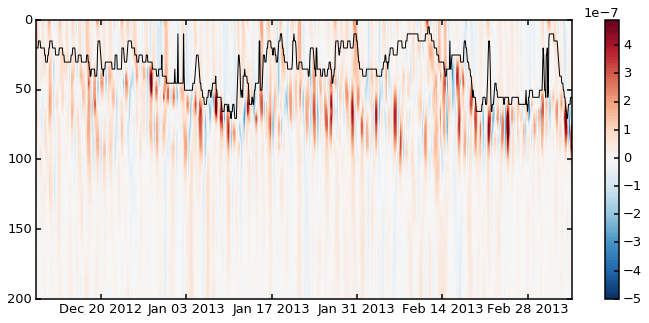

In [88]:
contourf(s1_time[1:], s1_dpth, s1_bx, levels=arange(-5e-7, 5e-7, 1e-8), cmap='RdBu_r')
date_plot(s1_time, s1_mld)

ylim(200, 0)

colorbar()

## SOSCEX 2

In [8]:
data = sio.loadmat('/Users/Marcel/Google Drive/Data/SOCCO_gliders/optimal_interpolated_grids/soscex2/oi_data_soscex2.mat')

a= data['ZI_t']
s2_temp = pd.DataFrame(a)

a= data['ZI_s']
s2_salt = pd.DataFrame(a)

a= data['ZI_d']
s2_dens = pd.DataFrame(a)

a= data['ZI_ln']
s2_lons = pd.DataFrame(a)

a= data['ZI_lt']
s2_lats = pd.DataFrame(a)

a= data['TI']
s2_time = pd.DataFrame(a)

a= data['DI']
s2_dpth = pd.DataFrame(a)

s2_temp = s2_temp.values.squeeze()
s2_salt = s2_salt.values.squeeze()
s2_dens = s2_dens.values.squeeze()
s2_lons = s2_lons.values.squeeze()
s2_lats = s2_lats.values.squeeze()
s2_time = s2_time.values.squeeze()
s2_dpth = s2_dpth.values.squeeze()

In [9]:
s2_dist = sw.dist(s2_lats[1, :], s2_lons[1, :], 'km')[0]

s2_buoy = 9.81*(1-s2_dens/1027)

s2_bx = diff(s2_buoy, axis=1) / np.mean(s2_dist*1000)


In [10]:
s2_mld = np.ndarray([1374])

for i in range(1374):
    
    ind = argmin(abs(abs(s2_dens[1, i] - s2_dens[1:, i])-0.03))
    s2_mld[i] = s2_dpth[ind+1]

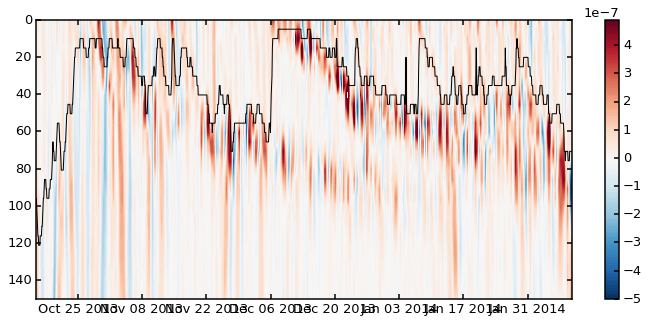

In [11]:
contourf(s2_time[1:], s2_dpth, s2_bx, levels=arange(-5e-7, 5e-7, 1e-8), cmap='RdBu_r')
date_plot(s2_time, s2_mld)

ylim(150, 0)

colorbar()

In [709]:
s2_bx.shape

(100, 1373)

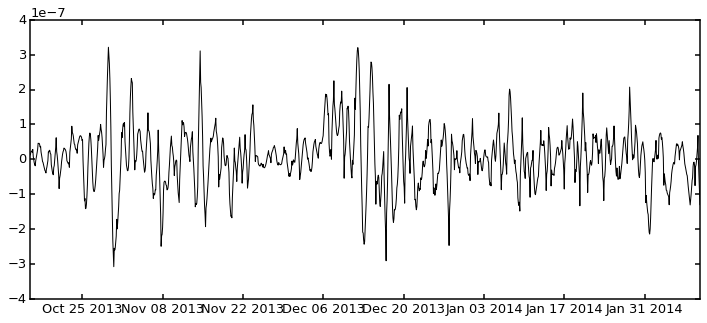

In [710]:
date_plot(s2_time[1:], s2_bx[1, :])

## SOSCEx 3

In [34]:
data = sio.loadmat('/Users/Marcel/Google Drive/Data/SOCCO_gliders/optimal_interpolated_grids/soscex3/oi_data_soscex3.mat')

a= data['ZI_t']
s3_temp = pd.DataFrame(a)

a= data['ZI_s']
s3_salt = pd.DataFrame(a)

a= data['ZI_d']
s3_dens = pd.DataFrame(a)

a= data['ZI_ln']
s3_lons = pd.DataFrame(a)

a= data['ZI_lt']
s3_lats = pd.DataFrame(a)

a= data['TI']
s3_time = pd.DataFrame(a)

a= data['DI']
s3_dpth = pd.DataFrame(a)

s3_temp = s3_temp.values.squeeze()
s3_salt = s3_salt.values.squeeze()
s3_dens = s3_dens.values.squeeze()
s3_lons = s3_lons.values.squeeze()
s3_lats = s3_lats.values.squeeze()
s3_time = s3_time.values.squeeze()
s3_dpth = s3_dpth.values.squeeze()

In [42]:
s3_dist = sw.dist(s3_lats[1, :], s3_lons[1, :], 'km')[0]

s3_buoy = 9.81*(1-s3_dens/1027)

s3_bx = diff(s3_buoy, axis=1) / np.mean(s3_dist*1000)


## SOSCEx 4

In [14]:
data = sio.loadmat('/Users/Marcel/Google Drive/Data/SOCCO_gliders/optimal_interpolated_grids/soscex4/oi_data_soscex4.mat')

a= data['ZI_t']
s4_temp = pd.DataFrame(a)

a= data['ZI_s']
s4_salt = pd.DataFrame(a)

a= data['ZI_d']
s4_dens = pd.DataFrame(a)

a= data['ZI_ln']
s4_lons = pd.DataFrame(a)

a= data['ZI_lt']
s4_lats = pd.DataFrame(a)

a= data['TI']
s4_time = pd.DataFrame(a)

a= data['DI']
s4_dpth = pd.DataFrame(a)

s4_temp = s4_temp.values.squeeze()
s4_salt = s4_salt.values.squeeze()
s4_dens = s4_dens.values.squeeze()
s4_lons = s4_lons.values.squeeze()
s4_lats = s4_lats.values.squeeze()
s4_time = s4_time.values.squeeze()
s4_dpth = s4_dpth.values.squeeze()

In [15]:
s4_dist = sw.dist(s4_lats[1, :], s4_lons[1, :], 'km')[0]

s4_buoy = 9.81*(1-s4_dens/1027)

s4_bx = diff(s4_buoy, axis=1) / np.mean(s4_dist*1000)


# Sensativity tests

These are sensativity tests to make sure that the interpolations are correctly reading in the glider data and are matching what we observe. Importantly, I am checking that the interpolated data exhibits the submesoscale variability that is shown in the raw observational data.

## Read in raw Seaglider data using my own script

This is done instead on using Luke's script because the dives are not loading correctly for using Buoyancy Glider Utils and so gridding the data to depth bins is not working.

In [50]:
from scipy.interpolate import griddata
def readSeagliderCTD(pathToData):
    
    flist = glob(pathToData)
    print 'Number of dives:', len(flist)
    
    t = []
    s = []
    tm = []
    dpt = []
    lt = []
    ln = []
    
    # define variables
    sal = []
    tem = []
    time = []
    dpt_curr_u = []
    dpt_curr_v = []
    sfc_curr_u = []
    sfc_curr_v = []
    lat = []
    lon = []
    
    for c, fname in enumerate(flist): 
   
        nco = Dataset(fname, 'r')
        dp = nco.variables['depth'][:]
        tmp = nco.variables['temperature'][:]
        slt = nco.variables['salinity'][:]
        tim = nco.variables['time'][:]
        lt = nco.variables['latitude_gsm'][:]
        ln = nco.variables['longitude_gsm'][:]
        sfc_curr_u += nco.variables['surface_curr_east'][:],
        sfc_curr_v += nco.variables['surface_curr_north'][:],
        dpt_curr_u += nco.variables['depth_avg_curr_east_gsm'][:],
        dpt_curr_v += nco.variables['depth_avg_curr_north_gsm'][:],
        nco.close()
        
        max_dpt = dp.argmax()
        
        x = np.argsort(dp[:max_dpt])
        
        if len(x) > 1:
            
            y = find(~isnan(tmp[x])==True)
            
            dpt += dp[x],
            t += griddata(dp[x][y], tmp[x][y], arange(1000), method='linear'),
            s += griddata(dp[x][y], slt[x][y], arange(1000), method='linear'),
            tm += griddata(dp[x][y], tim[x][y], arange(1000), method='linear'),
            lat += griddata(dp[x][y], lt[x][y], arange(1000), method='linear'),
            lon += griddata(dp[x][y], ln[x][y], arange(1000), method='linear'),
            
        x = np.argsort(dp[max_dpt:])+max_dpt
        
        if len(x) > 1:
            
            y = find(~isnan(tmp[x])==True)
            
            dpt += dp[x],
            t += griddata(dp[x][y], tmp[x][y], arange(1000), method='linear'),
            s += griddata(dp[x][y], slt[x][y], arange(1000), method='linear'),
            tm += griddata(dp[x][y], tim[x][y], arange(1000), method='linear'),
            lat += griddata(dp[x][y], lt[x][y], arange(1000), method='linear'),
            lon += griddata(dp[x][y], ln[x][y], arange(1000), method='linear'),

        
        
    close("all")
    
    return t, s, tm, dpt, lat, lon, sfc_curr_u, sfc_curr_v, dpt_curr_u, dpt_curr_v

### Load SOSCEx 1 raw Seaglider data

In [51]:
tmp1, slt1, tm1, dpt1, lt1, ln1, sfc_curr_u_s1, sfc_curr_v_s1, dpt_curr_u_s1, dpt_curr_v_s1 = readSeagliderCTD('/Users/Marcel/Google Drive/Data/SOCCO_gliders/soscex1/sg543/*.nc')

t_s1   = array(tmp1)
s_s1   = array(slt1)
tm_s1  = array(tm1)
dpt_s1 = array(dpt1)
lat_s1 = array(lt1)
lon_s1 = array(ln1)
sfc_curr_u_s1 = array(sfc_curr_u_s1)
sfc_curr_v_s1 = array(sfc_curr_v_s1)
dpt_curr_u_s1 = array(dpt_curr_u_s1)
dpt_curr_v_s1 = array(dpt_curr_v_s1)

tm_s1 = tm_s1/86400 + datestr2num('1970-01-01 00:00:00')

z = arange(1000)

t_s1   = t_s1.T
s_s1   = s_s1.T
tm_s1  = tm_s1.T
dpt_s1 = dpt_s1.T
lat_s1 = lat_s1.T
lon_s1 = lon_s1.T

time_s1 = tm_s1

Number of dives: 477


### Load SOSCEx 2 raw Seaglider data

In [52]:
tmp1, slt1, tm1, dpt1, lt1, ln1, scu1, scv1, dcu1, dcv1 = readSeagliderCTD('/Users/Marcel/Google Drive/Data/SOCCO_gliders/soscex2/sg574_saz/*.nc')
tmp2, slt2, tm2, dpt2, lt2, ln2, scu2, scv2, dcu2, dcv2 = readSeagliderCTD('/Users/Marcel/Google Drive/Data/SOCCO_gliders/soscex2/sg543/*.nc')

t1 = array(tmp1)
s1 = array(slt1)
tm1 = array(tm1)
dpt1 = array(dpt1)
lt1 = array(lt1)
ln1 = array(ln1)
scu1 = array(scu1)
scv1 = array(scv1)
dcu1 = array(dcu1)
dcv1 = array(dcv1)


tm1 = tm1/86400 + datestr2num('1970-01-01 00:00:00')

t2 = array(tmp2)
s2 = array(slt2)
tm2 = array(tm2)
dpt2 = array(dpt2)
lt2 = array(lt2)
ln2 = array(ln2)
scu2 = array(scu2)
scv2 = array(scv2)
dcu2 = array(dcu2)
dcv2 = array(dcv2)

tm2 = tm2/86400 + datestr2num('1970-01-01 00:00:00')

t_s2 = np.concatenate([t1, t2], axis=0)
s_s2 = np.concatenate([s1, s2], axis=0)
tm_s2 = np.concatenate([tm1, tm2], axis=0)
dpt_s2 = np.concatenate([dpt1, dpt2], axis=0)
lat_s2 = np.concatenate([lt1, lt2], axis=0)
lon_s2 = np.concatenate([ln1, ln2], axis=0)
sfc_curr_u_s2 = np.concatenate([scu1, scu2])
sfc_curr_v_s2 = np.concatenate([scv1, scv2])
dpt_curr_u_s2 = np.concatenate([dcu1, dcu2])
dpt_curr_v_s2 = np.concatenate([dcv1, dcv2])

z = arange(1000)

t_s2   = t_s2.T
s_s2   = s_s2.T
tm_s2  = tm_s2.T
dpt_s2 = dpt_s2.T
lat_s2 = lat_s2.T
lon_s2 = lon_s2.T

time_s2 = tm_s2

Number of dives: 188
Number of dives: 386


### Load SOSCEx 3 raw Seaglider data

In [53]:
tmp1, slt1, tm1, dpt1, lt1, ln1, scu1, scv1, dcu1, dcv1 = readSeagliderCTD('/Users/Marcel/Google Drive/Data/SOCCO_gliders/soscex3/sg543/*.nc')
tmp2, slt2, tm2, dpt2, lt2, ln2, scu2, scv2, dcu2, dcv2 = readSeagliderCTD('/Users/Marcel/Google Drive/Data/SOCCO_gliders/soscex3/sg542/*.nc')

t1 = array(tmp1)
s1 = array(slt1)
tm1 = array(tm1)
dpt1 = array(dpt1)
lt1 = array(lt1)
ln1 = array(ln1)
scu1 = array(scu1)
scv1 = array(scv1)
dcu1 = array(dcu1)
dcv1 = array(dcv1)

tm1 = tm1/86400 + datestr2num('1970-01-01 00:00:00')

t2 = array(tmp2)
s2 = array(slt2)
tm2 = array(tm2)
dpt2 = array(dpt2)
lt2 = array(lt2)
ln2 = array(ln2)
scu2 = array(scu2)
scv2 = array(scv2)
dcu2 = array(dcu2)
dcv2 = array(dcv2)

tm2 = tm2/86400 + datestr2num('1970-01-01 00:00:00')

t_s3 = np.concatenate([t1, t2], axis=0)
s_s3 = np.concatenate([s1, s2], axis=0)
tm_s3 = np.concatenate([tm1, tm2], axis=0)
dpt_s3 = np.concatenate([dpt1, dpt2], axis=0)
lat_s3 = np.concatenate([lt1, lt2], axis=0)
lon_s3 = np.concatenate([ln1, ln2], axis=0)
sfc_curr_u_s3 = np.concatenate([scu1, scu2])
sfc_curr_v_s3 = np.concatenate([scv1, scv2])
dpt_curr_u_s3 = np.concatenate([dcu1, dcu2])
dpt_curr_v_s3 = np.concatenate([dcv1, dcv2])

z = arange(1000)

t_s3   = t_s3.T
s_s3   = s_s3.T
tm_s3  = tm_s3.T
dpt_s3 = dpt_s3.T
lat_s3 = lat_s3.T
lon_s3 = lon_s3.T

time_s3 = tm_s3

Number of dives: 570
Number of dives: 336


### Load SOSCEx 4 raw Seaglider data

In [54]:
tmp1, slt1, tm1, dpt1, lt1, ln1, scu1, scv1, dcu1, dcv1 = readSeagliderCTD('/Users/Marcel/Google Drive/Data/SOCCO_gliders/soscex4/sg542/*.nc')
tmp2, slt2, tm2, dpt2, lt2, ln2, scu2, scv2, dcu2, dcv2 = readSeagliderCTD('/Users/Marcel/Google Drive/Data/SOCCO_gliders/soscex4/sg543/*.nc')

t1 = array(tmp1)
s1 = array(slt1)
tm1 = array(tm1)
dpt1 = array(dpt1)
lt1 = array(lt1)
ln1 = array(ln1)
scu1 = array(scu1)
scv1 = array(scv1)
dcu1 = array(dcu1)
dcv1 = array(dcv1)

tm1 = tm1/86400 + datestr2num('1970-01-01 00:00:00')

t2 = array(tmp2)
s2 = array(slt2)
tm2 = array(tm2)
dpt2 = array(dpt2)
lt2 = array(lt2)
ln2 = array(ln2)
scu2 = array(scu2)
scv2 = array(scv2)
dcu2 = array(dcu2)
dcv2 = array(dcv2)



tm2 = tm2/86400 + datestr2num('1970-01-01 00:00:00')

t_s4 = np.concatenate([t1, t2], axis=0)
s_s4 = np.concatenate([s1, s2], axis=0)
tm_s4 = np.concatenate([tm1, tm2], axis=0)
dpt_s4 = np.concatenate([dpt1, dpt2], axis=0)
lat_s4 = np.concatenate([lt1, lt2], axis=0)
lon_s4 = np.concatenate([ln1, ln2], axis=0)
sfc_curr_u_s4 = np.concatenate([scu1, scu2])
sfc_curr_v_s4 = np.concatenate([scv1, scv2])
dpt_curr_u_s4 = np.concatenate([dcu1, dcu2])
dpt_curr_v_s4 = np.concatenate([dcv1, dcv2])

z = arange(1000)

t_s4   = t_s4.T
s_s4   = s_s4.T
tm_s4  = tm_s4.T
dpt_s4 = dpt_s4.T
lat_s4 = lat_s4.T
lon_s4 = lon_s4.T

time_s4 = tm_s4

Number of dives: 661
Number of dives: 84


## Mixed layer temperature comparisons

### SOSCEx 1 mixed layer temperature comparison

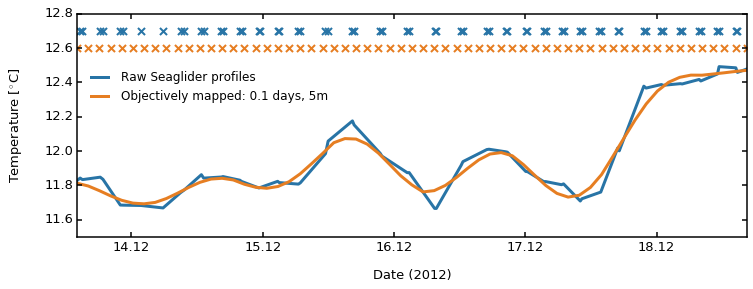

In [120]:
fig, ax = subplots(figsize=[12, 4])

# plot the 10m temperature of the raw seaglider profiles 
ax.plot_date(time_s1[10, :], t_s1[10, :], lw=3, ms=0, ls='-', label='Raw Seaglider profiles', c='#2874A6')

# plot the 10m temperature of the objectively mapped data
ax.plot(s1_time, s1_temp[2, :], 'r', lw=3, label='Objectively mapped: 0.1 days, 5m', c='#E67E22')

ax.legend(frameon=False, fontsize=12, loc=3, bbox_to_anchor=(0,0.55))
ax.set_ylabel("Temperature [$^{\circ}$C]", labelpad=20)
ax.set_xlabel('Date (2012)', labelpad=15)
ax.set_ylim(11.5, 12.8)

# make the dateticks to weekly intervals
ax.xaxis.set_major_locator(DayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%d.%m'))

ax.set_xlim(s1_time[50], s1_time[110])

scatter(time_s1[10, :], zeros(len(time_s1[10, :]))+12.7, 50, color='#2874A6', marker='x', lw=2)
scatter(s1_time, zeros(len(s1_time))+12.6, 50, color='#E67E22', marker='x', lw=2)

savefig('/Users/Marcel/Google Drive/Projects/STRATIFICATION_EBF_JPO/Figures/Sens_ML_temp_S1.png', dpi=300)

### SOSCEx 2 mixed layer temperature comparison

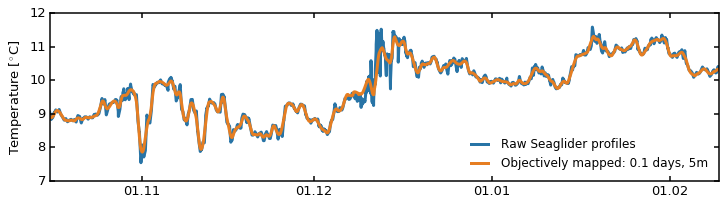

In [187]:
fig, ax = subplots(figsize=[12, 3])

# plot the 10m temperature of the raw seaglider profiles 
ax.plot_date(time_s2[10, :], t_s2[10, :], lw=3, ms=0, ls='-', label='Raw Seaglider profiles', c='#2874A6')

# plot the 10m temperature of the objectively mapped data
ax.plot(s2_time, s2_temp[2, :], 'r', lw=3, label='Objectively mapped: 0.1 days, 5m', c='#E67E22')

ax.legend(frameon=False, fontsize=12, loc=4)
ax.set_ylabel("Temperature [$^{\circ}$C]")
ax.set_ylim(7, 12)

# make the dateticks to weekly intervals
ax.xaxis.set_major_locator(MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%d.%m'))

savefig('/Users/Marcel/Google Drive/Projects/STRATIFICATION_EBF_JPO/Figures/Sens_ML_temp_S2.png', dpi=300)

### SOSCEx 3 mixed layer temperature comparison

(735901.08230324078, 735909.58230324078)

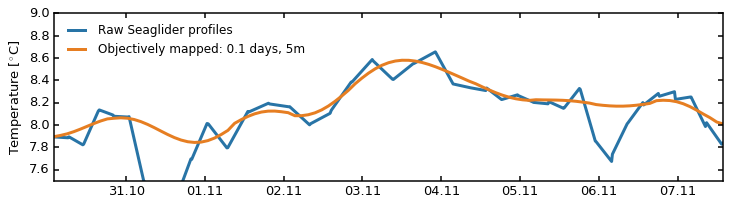

In [243]:
fig, ax = subplots(figsize=[12, 3])

# plot the 10m temperature of the raw seaglider profiles 
ax.plot_date(time_s3[10, :], t_s3[10, :], lw=3, ms=0, ls='-', label='Raw Seaglider profiles', c='#2874A6')

# plot the 10m temperature of the objectively mapped data
ax.plot(s3_time, s3_temp[2, :], 'r', lw=3, label='Objectively mapped: 0.1 days, 5m', c='#E67E22')

ax.legend(frameon=False, fontsize=12, loc=2)
ax.set_ylabel("Temperature [$^{\circ}$C]")
ax.set_ylim(7.5, 9)

# make the dateticks to weekly intervals
ax.xaxis.set_major_locator(DayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%d.%m'))

ax.set_xlim(s3_time[1100], s3_time[1200])

# savefig('/Users/Marcel/Google Drive/Projects/STRATIFICATION_EBF_JPO/Figures/Sens_ML_temp_S3.png', dpi=300)

### SOSCEx 4 mixed layer temperature comparison

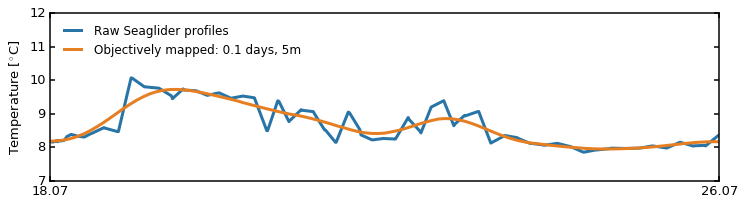

In [65]:
fig, ax = subplots(figsize=[12, 3])

# plot the 10m temperature of the raw seaglider profiles 
ax.plot_date(time_s4[10, :], t_s4[10, :], lw=3, ms=0, ls='-', label='Raw Seaglider profiles', c='#2874A6')

# plot the 10m temperature of the objectively mapped data
ax.plot(s4_time, s4_temp[2, :], 'r', lw=3, label='Objectively mapped: 0.1 days, 5m', c='#E67E22')

ax.legend(frameon=False, fontsize=12, loc=2)
ax.set_ylabel("Temperature [$^{\circ}$C]")
ax.set_ylim(7, 12)

# make the dateticks to weekly intervals
ax.xaxis.set_major_locator(MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%d.%m'))

ax.set_xlim(s4_time[0], s4_time[100])

savefig('/Users/Marcel/Google Drive/Projects/STRATIFICATION_EBF_JPO/Figures/Sens_ML_temp_S4.png', dpi=300)

## Time interpolation tests

### Load the different time interpolation data

#### 0.5 hour gridding

In [45]:
data = sio.loadmat('/Users/Marcel/Google Drive/Data/SOCCO_gliders/optimal_interpolated_grids/soscex1/oi_data_soscex1_05hrs_5m.mat')

a= data['ZI_d']
dens = pd.DataFrame(a)

a= data['ZI_ln']
lons = pd.DataFrame(a)

a= data['ZI_lt']
lats = pd.DataFrame(a)

a= data['TI']
time = pd.DataFrame(a)

a= data['DI']
dpth = pd.DataFrame(a)

dens_05hrs = dens.values.squeeze()
lons_05hrs = lons.values.squeeze()
lats_05hrs = lats.values.squeeze()
time_05hrs = time.values.squeeze()
dpth_05hrs = dpth.values.squeeze()

#### 1 hour gridding

In [46]:
data = sio.loadmat('/Users/Marcel/Google Drive/Data/SOCCO_gliders/optimal_interpolated_grids/soscex1/oi_data_soscex1_1hrs_5m.mat')

a= data['ZI_d']
dens = pd.DataFrame(a)

a= data['ZI_ln']
lons = pd.DataFrame(a)

a= data['ZI_lt']
lats = pd.DataFrame(a)

a= data['TI']
time = pd.DataFrame(a)

a= data['DI']
dpth = pd.DataFrame(a)

dens_1hrs = dens.values.squeeze()
lons_1hrs = lons.values.squeeze()
lats_1hrs = lats.values.squeeze()
time_1hrs = time.values.squeeze()
dpth_1hrs = dpth.values.squeeze()

#### 2 hour gridding

In [18]:
data = sio.loadmat('/Users/Marcel/Google Drive/Data/SOCCO_gliders/optimal_interpolated_grids/soscex1/oi_data_soscex1_2hrs_5m.mat')

a= data['ZI_d']
dens = pd.DataFrame(a)

a= data['ZI_ln']
lons = pd.DataFrame(a)

a= data['ZI_lt']
lats = pd.DataFrame(a)

a= data['TI']
time = pd.DataFrame(a)

a= data['DI']
dpth = pd.DataFrame(a)

dens_2hrs = dens.values.squeeze()
lons_2hrs = lons.values.squeeze()
lats_2hrs = lats.values.squeeze()
time_2hrs = time.values.squeeze()
dpth_2hrs = dpth.values.squeeze()

### Buoyancy gradient plots

In [47]:
dist_05hrs = sw.dist(lats_05hrs[1, :], lons_05hrs[1, :], 'km')[0]

buoy_05hrs = 9.81*(1-dens_05hrs/1027)

bx_05hrs = diff(buoy_05hrs, axis=1) / np.mean(dist_05hrs*1000)


In [48]:
dist_1hrs = sw.dist(lats_1hrs[1, :], lons_1hrs[1, :], 'km')[0]

buoy_1hrs = 9.81*(1-dens_1hrs/1027)

bx_1hrs = diff(buoy_1hrs, axis=1) / np.mean(dist_1hrs*1000)


In [21]:
dist_2hrs = sw.dist(lats_2hrs[1, :], lons_2hrs[1, :], 'km')[0]

buoy_2hrs = 9.81*(1-dens_2hrs/1027)

bx_2hrs = diff(buoy_2hrs, axis=1) / (dist_2hrs*1000)


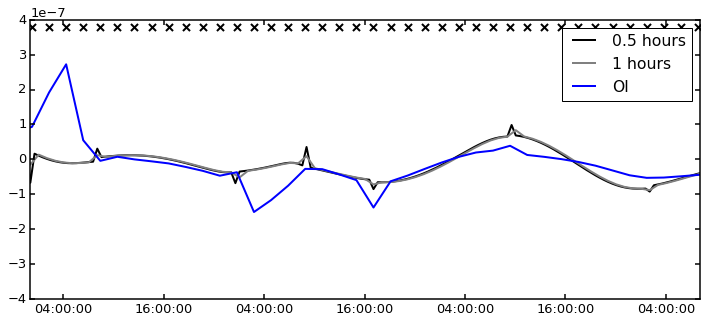

In [49]:
date_plot(time_05hrs[1:], bx_05hrs[2, :], c='k', lw=2, label='0.5 hours')
date_plot(time_1hrs[1:], bx_1hrs[2, :], c='0.5', lw=2, label='1 hours')
# date_plot(time_2hrs[1:], bx_2hrs[2, :], c='r', lw=2, label='2 hours')
date_plot(s1_time[1:], s1_bx[2, :], c='b', lw=2, label='OI')

legend()
ylim(-0.4e-6, 0.4e-6)

xlim(time_1hrs[520], time_1hrs[600])

scatter(s1_time[1:], zeros(len(s1_time[1:]))+0.38e-6, 50, color='k', marker='x', lw=2)

(0, 1e-06)

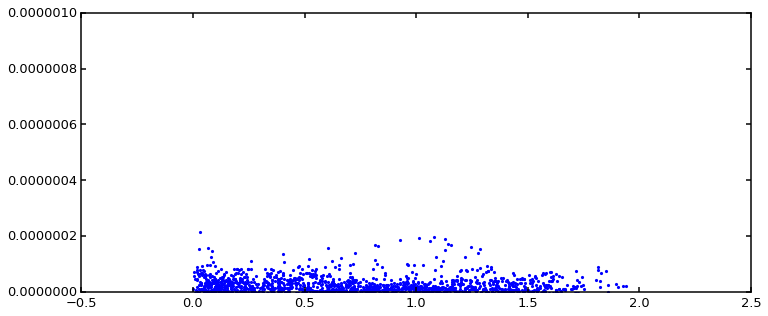

In [43]:
scatter(s3_dist, s3_bx[2, :], 10, c='b', lw=0, label='OI')

ylim(0, 1e-6)


# Publication plots

## Figure 3: Mixed layer temperature and salinity

Mixed layer temperature (a) and salinity (b) structure observed from the gliders for the four SOSCEx
studies. Thermal expansion and haline contraction coefficients a and b scale the ranges of axes proportionally,
such that equal displacements in temperature and salinity have an equal effect on density.

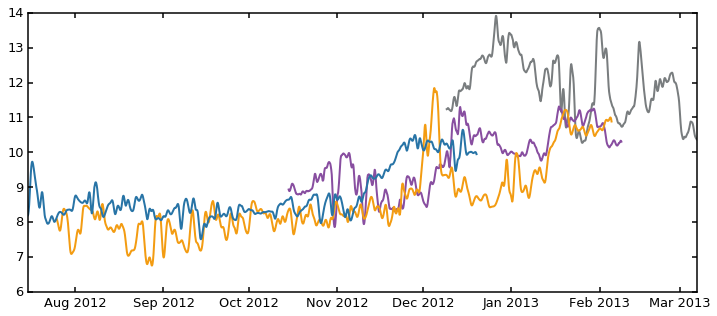

In [237]:
date_plot(s1_time, s1_temp[2, :], lw=2, c='#797D7F')
date_plot(s2_time-366*1, s2_temp[2, :], lw=2, c='#884EA0')
date_plot(s3_time-366*3, s3_temp[2, :], lw=2, c='#F39C12')
date_plot(s4_time-366*4, s4_temp[2, :], lw=2, c='#2874A6')

# xlim(s3_time[1000], s3_time[1110]+15)